# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [2]:
# Start ray locally (there are lots of configurations)
ray.init(num_cpus=4, ignore_reinit_error=True, log_to_driver=False)

2020-03-04 15:57:39,826	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-04 15:57:39,831	INFO resource_spec.py:212 -- Starting Ray with 37.6 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-04 15:57:40,311	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
2020-03-04 15:57:40,318	WARNING services.py:1403 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:34143',
 'object_store_address': '/tmp/ray/session_2020-03-04_15-57-39_824848_35/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-04_15-57-39_824848_35/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-04_15-57-39_824848_35'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [3]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2, 'num_envs_per_worker': 1, 'sample_batch_size': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}, 'custom_preprocessor': None}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_level': 'WARN', 'callbacks': {'on_episode_start': None, 'on_episode_step': None, 'on_episode_end': Non

In [4]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'CartPole-v0')

2020-03-04 15:57:41,248	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-04 15:57:41,269	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
2020-03-04 15:57:41,272	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/conda/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-04 15:57:41,466	WARNING worker.py:1058 -- The dashboard on node af27f73862c9 failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/

In [5]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-03-04_15-57-58
done: false
episode_len_mean: 22.353932584269664
episode_reward_max: 89.0
episode_reward_mean: 22.353932584269664
episode_reward_min: 10.0
episodes_this_iter: 178
episodes_total: 178
experiment_id: 854cae551b5843ef98a187d809a9731d
hostname: af27f73862c9
info:
  grad_time_ms: 2344.363
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6640250086784363
      entropy_coeff: 0.0
      kl: 0.030091295018792152
      policy_loss: -0.039826083928346634
      total_loss: 137.75889587402344
      vf_explained_var: 0.034579798579216
      vf_loss: 137.7926788330078
  load_time_ms: 72.596
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 8583.601
  update_time_ms: 522.156
iterations_since_restore: 1
node_ip: 172.17.0.2
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 14.282352941176471
  ram_util_percent: 18.98235294117647
pid: 35
polic

In [6]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [7]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[-1.8682804e+00 -2.0490057e+38 -4.0107661e-01 -2.6536361e+38]


In [9]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [10]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

2020-03-04 15:58:06,020	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
/opt/conda/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-04 15:58:10,153	WARNING util.py:37 -- Install gputil for GPU system monitoring.


In [11]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-03-04_15-58-16
done: false
episode_len_mean: 21.900552486187845
episode_reward_max: 95.0
episode_reward_mean: 21.900552486187845
episode_reward_min: 8.0
episodes_this_iter: 181
episodes_total: 181
experiment_id: 981f8facd69f43fc9a65b9028233dadd
hostname: af27f73862c9
info:
  grad_time_ms: 2239.453
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6628535985946655
      entropy_coeff: 0.0
      kl: 0.03046100027859211
      policy_loss: -0.03643565624952316
      total_loss: 174.53184509277344
      vf_explained_var: 0.03705925494432449
      vf_loss: 174.56216430664062
  load_time_ms: 62.583
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 3262.039
  update_time_ms: 631.169
iterations_since_restore: 1
node_ip: 172.17.0.2
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 24.32
  ram_util_percent: 19.52
pid: 35
policy_reward_max: {}
policy_r

custom_metrics: {}
date: 2020-03-04_15-58-38
done: false
episode_len_mean: 163.14
episode_reward_max: 200.0
episode_reward_mean: 163.14
episode_reward_min: 13.0
episodes_this_iter: 21
episodes_total: 427
experiment_id: 981f8facd69f43fc9a65b9028233dadd
hostname: af27f73862c9
info:
  grad_time_ms: 1817.669
  learner:
    default_policy:
      cur_kl_coeff: 0.30000001192092896
      cur_lr: 4.999999873689376e-05
      entropy: 0.5416647791862488
      entropy_coeff: 0.0
      kl: 0.002818094799295068
      policy_loss: -0.0009219517232850194
      total_loss: 509.164306640625
      vf_explained_var: 0.04579988867044449
      vf_loss: 509.1644592285156
  load_time_ms: 11.098
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 2020.249
  update_time_ms: 93.12
iterations_since_restore: 7
node_ip: 172.17.0.2
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 22.619999999999997
  ram_util_percent: 19.5
pid: 35
policy_reward_max: {}
policy_reward_mean:

custom_metrics: {}
date: 2020-03-04_15-58-59
done: false
episode_len_mean: 197.93
episode_reward_max: 200.0
episode_reward_mean: 197.93
episode_reward_min: 128.0
episodes_this_iter: 20
episodes_total: 549
experiment_id: 981f8facd69f43fc9a65b9028233dadd
hostname: af27f73862c9
info:
  grad_time_ms: 1820.087
  learner:
    default_policy:
      cur_kl_coeff: 0.01875000074505806
      cur_lr: 4.999999873689376e-05
      entropy: 0.5463908314704895
      entropy_coeff: 0.0
      kl: 0.007513274904340506
      policy_loss: -0.003791114082559943
      total_loss: 371.29107666015625
      vf_explained_var: 0.19435717165470123
      vf_loss: 371.29473876953125
  load_time_ms: 2.718
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 1791.978
  update_time_ms: 4.344
iterations_since_restore: 13
node_ip: 172.17.0.2
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 24.0
  ram_util_percent: 19.52
pid: 35
policy_reward_max: {}
policy_reward_mean: {}
policy

custom_metrics: {}
date: 2020-03-04_15-59-21
done: false
episode_len_mean: 199.15
episode_reward_max: 200.0
episode_reward_mean: 199.15
episode_reward_min: 180.0
episodes_this_iter: 20
episodes_total: 669
experiment_id: 981f8facd69f43fc9a65b9028233dadd
hostname: af27f73862c9
info:
  grad_time_ms: 1798.823
  learner:
    default_policy:
      cur_kl_coeff: 0.00937500037252903
      cur_lr: 4.999999873689376e-05
      entropy: 0.5689409971237183
      entropy_coeff: 0.0
      kl: 0.006725978571921587
      policy_loss: -0.0030845978762954473
      total_loss: 126.54732513427734
      vf_explained_var: 0.7361378073692322
      vf_loss: 126.55033874511719
  load_time_ms: 2.689
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 1754.205
  update_time_ms: 4.477
iterations_since_restore: 19
node_ip: 172.17.0.2
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 25.459999999999997
  ram_util_percent: 19.7
pid: 35
policy_reward_max: {}
policy_reward_me

In [12]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/root/ray_results/PPO_CartPole-v0_2020-03-04_15-58-06e1rblun3/checkpoint_20/checkpoint-20


In [13]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

2020-03-04 16:02:11,138	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/conda/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-04 16:02:14,936	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-04 16:02:15,001	WARNING trainable.py:210 -- Getting current IP.
2020-03-04 16:02:15,002	INFO trainable.py:416 -- Restored on 172.17.0.2 from checkpoint: /root/ray_results/PPO_CartPole-v0_2020-03-04_15-58-06e1rblun3/checkpoint_20/checkpoint-20
2020-03-04 16:02:15,002	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': 

### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [14]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


200.0


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [15]:
# matplotlib and magic
# ! pip install matplotlib
%matplotlib notebook

In [16]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/root/ray_results/PPO_CartPole-v0_2020-03-04_15-58-06e1rblun3")

# analysis = Analysis("/root/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37")

In [17]:
df = analysis.dataframe() # last trial from checkpoint

In [18]:
df_trials = analysis.trial_dataframes['/root/ray_results/PPO_CartPole-v0_2020-03-04_15-58-06e1rblun3']
# df_trials = analysis.trial_dataframes['/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_06-16-28270n8w37']

<IPython.core.display.Javascript object>


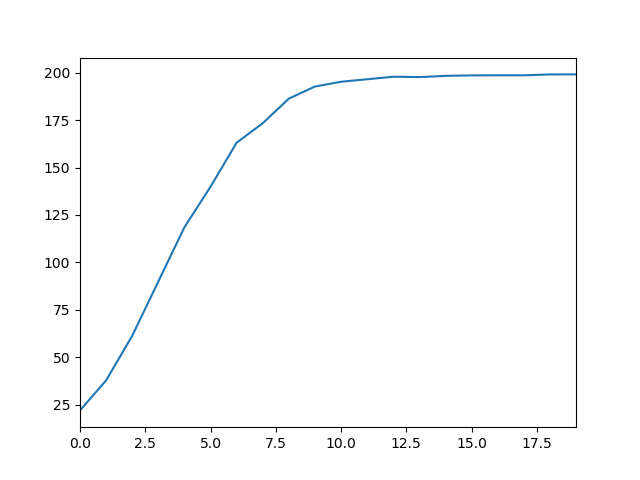

In [19]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [72]:
# ! pip install tensorboard

In [29]:
! tensorboard --logdir=~/ray_results --port=9999 # Kernel -> interupt to stop

TensorBoard 1.15.0 at http://d9c1395b1459:6006/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [76]:
! pip install pyyaml # install package to read yamls, import with yaml

In [20]:
import yaml
import urllib

In [21]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-a3c.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# This gets to ~19-20 reward in ~30 minutes / 4m steps on a m4.10xl instance\n# TODO(rliaw): this has regressed in performance\npong-a3c:\n    env: PongDeterministic-v4\n    run: A3C\n    config:\n        num_workers: 16\n        sample_batch_size: 20\n        use_pytorch: false\n        vf_loss_coeff: 0.5\n        entropy_coeff: 0.01\n        gamma: 0.99\n        grad_clip: 40.0\n        lambda: 1.0\n        lr: 0.0001\n        observation_filter: NoFilter\n        preprocessor_pref: rllib\n        model:\n            use_lstm: true\n            conv_activation: elu\n            dim: 42\n            grayscale: true\n            zero_mean: false\n            # Reduced channel depth and kernel size from default\n            conv_filters: [\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n            ]\n'


In [22]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 16, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}}}


In [23]:
tune_config_example["pong-a3c"]["config"]["num_workers"]=2
tune_config_example["pong-a3c"]["stop"] = {"training_iteration": 10}
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 2, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}, 'stop': {'training_iteration': 10}}}


In [24]:
ray.tune.run_experiments(tune_config_example)

2020-03-04 16:02:57,031	ERROR syncer.py:39 -- Log sync requires rsync to be installed.


Trial name,status,loc
A3C_PongDeterministic-v4_9d17eff8,RUNNING,


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-12
  done: false
  episode_len_mean: 820.0
  episode_reward_max: -21.0
  episode_reward_mean: -21.0
  episode_reward_min: -21.0
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.504
    dispatch_time_ms: 4.796
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 9.672812461853027
      model: {}
      policy_entropy: 35.81401443481445
      policy_loss: 6.255337238311768
      var_gnorm: 25.885271072387695
      vf_explained_var: -0.2074357271194458
      vf_loss: 0.33402764797210693
    num_steps_sampled: 2000
    num_steps_trained: 2000
    wait_time_ms: 30.377
  iterations_since_restore: 1
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 20.76666666666667
    ram_util_percent: 23.686666666666667
  pid: 353


Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-21,9.90563,2000,1


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-20
  done: false
  episode_len_mean: 904.4
  episode_reward_max: -19.0
  episode_reward_mean: -20.4
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 5
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.574
    dispatch_time_ms: 4.987
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 9.978023529052734
      model: {}
      policy_entropy: 35.75037384033203
      policy_loss: 6.5493950843811035
      var_gnorm: 25.895015716552734
      vf_explained_var: -0.17675864696502686
      vf_loss: 0.36715227365493774
    num_steps_sampled: 6000
    num_steps_trained: 6000
    wait_time_ms: 31.196
  iterations_since_restore: 2
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 28.309999999999995
    ram_util_percent: 24.0
  pid: 353
  policy_re

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.4,17.0515,6000,2


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-27
  done: false
  episode_len_mean: 931.9
  episode_reward_max: -19.0
  episode_reward_mean: -20.3
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 10
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.573
    dispatch_time_ms: 4.82
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 13.305801391601562
      model: {}
      policy_entropy: 35.7344970703125
      policy_loss: 6.718070983886719
      var_gnorm: 25.905691146850586
      vf_explained_var: 0.15502434968948364
      vf_loss: 0.5448382496833801
    num_steps_sampled: 10000
    num_steps_trained: 10000
    wait_time_ms: 29.493
  iterations_since_restore: 3
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.879999999999995
    ram_util_percent: 24.0
  pid: 353
  policy_rew

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.3,24.1877,10000,3


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-34
  done: false
  episode_len_mean: 913.2142857142857
  episode_reward_max: -19.0
  episode_reward_mean: -20.428571428571427
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 14
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 2.431
    dispatch_time_ms: 8.692
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 5.603128433227539
      model: {}
      policy_entropy: 35.785133361816406
      policy_loss: -3.230623722076416
      var_gnorm: 25.91425895690918
      vf_explained_var: 0.0626024603843689
      vf_loss: 1.5249757766723633
    num_steps_sampled: 14000
    num_steps_trained: 14000
    wait_time_ms: 30.828
  iterations_since_restore: 4
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 28.027272727272727
    ram_util_percent: 2

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.4286,31.4067,14000,4


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-41
  done: false
  episode_len_mean: 913.9473684210526
  episode_reward_max: -19.0
  episode_reward_mean: -20.42105263157895
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 19
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.604
    dispatch_time_ms: 4.972
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 35.724822998046875
      policy_loss: 40.379737854003906
      var_gnorm: 25.932632446289062
      vf_explained_var: 0.03856581449508667
      vf_loss: 12.452535629272461
    num_steps_sampled: 18000
    num_steps_trained: 18000
    wait_time_ms: 30.181
  iterations_since_restore: 5
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 28.439999999999998
    ram_util_percent: 24.0099999999

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.4211,38.6376,18000,5


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-49
  done: false
  episode_len_mean: 916.5652173913044
  episode_reward_max: -19.0
  episode_reward_mean: -20.434782608695652
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 23
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.553
    dispatch_time_ms: 4.996
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 7.161802291870117
      model: {}
      policy_entropy: 35.80634689331055
      policy_loss: 3.2941999435424805
      var_gnorm: 25.944604873657227
      vf_explained_var: 0.0029311776161193848
      vf_loss: 0.7741392254829407
    num_steps_sampled: 22000
    num_steps_trained: 22000
    wait_time_ms: 29.542
  iterations_since_restore: 6
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.74
    ram_util_percent: 24.07
  pid

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.4348,45.8305,22000,6


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-03-56
  done: false
  episode_len_mean: 917.8888888888889
  episode_reward_max: -19.0
  episode_reward_mean: -20.40740740740741
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 27
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.681
    dispatch_time_ms: 5.249
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 8.96703052520752
      model: {}
      policy_entropy: 35.80378341674805
      policy_loss: 6.355423927307129
      var_gnorm: 25.962169647216797
      vf_explained_var: 0.05139070749282837
      vf_loss: 0.4432685673236847
    num_steps_sampled: 26000
    num_steps_trained: 26000
    wait_time_ms: 30.114
  iterations_since_restore: 7
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.820000000000004
    ram_util_percent: 24.

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.4074,52.9429,26000,7


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-04-03
  done: false
  episode_len_mean: 928.8709677419355
  episode_reward_max: -17.0
  episode_reward_mean: -20.29032258064516
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 31
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.61
    dispatch_time_ms: 4.942
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 11.990363121032715
      model: {}
      policy_entropy: 35.743560791015625
      policy_loss: 7.616125106811523
      var_gnorm: 25.967660903930664
      vf_explained_var: 0.082927405834198
      vf_loss: 0.7093896865844727
    num_steps_sampled: 30000
    num_steps_trained: 30000
    wait_time_ms: 30.793
  iterations_since_restore: 8
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 28.09090909090909
    ram_util_percent: 24.1

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.2903,60.1012,30000,8


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-04-10
  done: false
  episode_len_mean: 925.9428571428572
  episode_reward_max: -17.0
  episode_reward_mean: -20.34285714285714
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 35
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.807
    dispatch_time_ms: 6.075
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 9.824254035949707
      model: {}
      policy_entropy: 35.70308303833008
      policy_loss: 7.222458362579346
      var_gnorm: 25.987089157104492
      vf_explained_var: 0.004716336727142334
      vf_loss: 0.5531505346298218
    num_steps_sampled: 34000
    num_steps_trained: 34000
    wait_time_ms: 29.503
  iterations_since_restore: 9
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 28.77
    ram_util_percent: 24.1
  pid: 35

2020-03-04 16:04:11,611	WARNING util.py:132 -- The `process_trial` operation took 1.1385910511016846 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,RUNNING,172.17.0.2:353,-20.3429,67.2306,34000,9


Result for A3C_PongDeterministic-v4_9d17eff8:
  custom_metrics: {}
  date: 2020-03-04_16-04-18
  done: true
  episode_len_mean: 927.475
  episode_reward_max: -17.0
  episode_reward_mean: -20.35
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 40
  experiment_id: a4dcb02ee01c46039006edff7a59ac67
  experiment_tag: '0'
  hostname: af27f73862c9
  info:
    apply_time_ms: 1.552
    dispatch_time_ms: 5.38
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 8.698119163513184
      model: {}
      policy_entropy: 35.717926025390625
      policy_loss: 7.213077545166016
      var_gnorm: 26.0128173828125
      vf_explained_var: -0.0043523311614990234
      vf_loss: 0.5089849829673767
    num_steps_sampled: 38000
    num_steps_trained: 38000
    wait_time_ms: 29.287
  iterations_since_restore: 10
  node_ip: 172.17.0.2
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 26.516666666666666
    ram_util_percent: 24.100000000000005
  pi

Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,TERMINATED,,-20.35,74.3091,38000,10


Trial name,status,loc,reward,total time (s),ts,iter
A3C_PongDeterministic-v4_9d17eff8,TERMINATED,,-20.35,74.3091,38000,10


[A3C_PongDeterministic-v4_9d17eff8]

# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [25]:
ray.is_initialized()

True

In [26]:
ray.nodes()

[{'NodeID': 'fe79205044135b4e863f4ea5dec08835a6a281c9',
  'Alive': True,
  'NodeManagerAddress': '172.17.0.2',
  'NodeManagerHostname': 'af27f73862c9',
  'NodeManagerPort': 60878,
  'ObjectManagerPort': 38113,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-03-04_15-57-39_824848_35/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-03-04_15-57-39_824848_35/sockets/raylet',
  'Resources': {'node:172.17.0.2': 1.0,
   'CPU': 4.0,
   'memory': 770.0,
   'GPU': 2.0,
   'object_store_memory': 263.0},
  'alive': True}]

In [27]:
ray.cluster_resources()

{'node:172.17.0.2': 1.0,
 'CPU': 4.0,
 'memory': 770.0,
 'GPU': 2.0,
 'object_store_memory': 263.0}

In [28]:
ray.shutdown()

In [29]:
ray.is_initialized()

False